In [1]:
import pydicom
import os
import sys
import numpy as np
import nibabel as nib
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
import time
import glob
from matplotlib import pyplot

now=time.localtime(time.time())

In [2]:
def converter(id):
    NiftiPath = "C:/Users/BMPL/Desktop/dicom import/p{}/nifti/".format(id)
    DicomPath = "C:/Users/BMPL/Desktop/dicom import/p{}/dicom/".format(id)

    img1 = nib.load(NiftiPath+'aseg.nii')
    img2 = nib.load(NiftiPath+'skull.nii')
    contour1 = np.array(img1.dataobj)
    contour1 = np.transpose(contour1, (2,1,0)) # 뇌 세그 
    print(contour1.dtype)
    contour2 = np.array(img2.dataobj)
    contour2 = np.transpose(contour2, (2,1,0)) # 본 세그 
    
    if np.max(contour1) == 44:
        contour1 = np.where((contour1==1)|(contour1==5)|(contour1==13)|(contour1==19)|
                            (contour1==21)|(contour1==25)|(contour1==35)|(contour1==37)|
                            ((39<=contour1)&(contour1<=44)), 1 , contour1) # 화이트 매터 컨버터 
    
        contour1 = np.where((contour1==2)|((6<=contour1)&(contour1<=10))|((14<=contour1)&(contour1<=15))|
                            ((17<=contour1)&(contour1<=18))|((26<=contour1)&(contour1<=34))|
                            (contour1==22), 2 , contour1)  # 그레이 매터 컨버터
    
        contour1 = np.where(((3<=contour1)&(contour1<=4))|((11<=contour1)&(contour1<=12))|(contour1==16)|
                            (contour1==20)|((23<=contour1)&(contour1<=24))|
                            (contour1==36)|(contour1==38), 0 , contour1) # CSF 컨버터 0 으로 해야 뒤에 CFS 베이스로 할때 4이 된다.
    
    
    elif np.max(contour1) == 45:
        contour1 = np.where((contour1==1)|(contour1==5)|(contour1==13)|(contour1==19)|
                            (contour1==21)|(contour1==25)|(contour1==35)|(contour1==38)|
                            ((40<=contour1)&(contour1<=45)), 1 , contour1) # 화이트 매터 컨버터 
    
        contour1 = np.where((contour1==2)|((6<=contour1)&(contour1<=10))|((14<=contour1)&(contour1<=15))|
                            ((17<=contour1)&(contour1<=18))|((26<=contour1)&(contour1<=34))|
                            (contour1==22), 2 , contour1)  # 그레이 매터 컨버터
    
        contour1 = np.where(((3<=contour1)&(contour1<=4))|((11<=contour1)&(contour1<=12))|(contour1==16)|
                            (contour1==20)|((23<=contour1)&(contour1<=24))|
                            (contour1==36)|(contour1==37)|(contour1==39), 0 , contour1) # CSF 컨버터 0 으로 해야 뒤에 CFS 베이스로 할때 4이 된다.
    
    else :
        print('Bug!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
    
    contour2_filter =  np. where(contour2==4, 1 , 0)
    
    contour1_filted = contour1 * contour2_filter
    
    
    contour3 = contour1_filted + contour2
    contour3 = np.int16(contour3)
    '''contour3 는 총 7개의 영역을 가지게 된다. 그 내용은 아래와 같다. 
    0 : 배경 
    1 : Skin
    2 : Bone
    3 : Cavity
    4 : CSF
    5 : White Matter
    6 : Grey Matter  
    '''
    
    
    dcm_list = glob.glob(os.path.join(DicomPath, "*.dcm"))
    slices = [pydicom.read_file(dcm) for dcm in dcm_list] # dcm_list에서 받은 .dcm 파일들의 경로를 하나씩 불러들여 pydicom의 read_file함수로 이미지를 읽어들인다.
    slices.sort(key = lambda x: float(x.InstanceNumber)) # 불러들인 slices는 파일 이름 순서로 sort되어 있는데, 파일 이름 순서는 항상 slice 순서를 따르지는 않는다. 따라서 InstanceNumber tag로 sort해준다.
    # RescaleSloope / Intercept tag가 존재하는 경우, 이를 계산하여 array로 stack하고, tag가 존재하지 않으면 계산하지 않고 array로 stack한다.
    if ('RescaleIntercept' in slices[0] and 'RescaleSlope' in slices[0]):
        slope = slices[0].RescaleSlope
        intercept = slices[0].RescaleIntercept
        image = np.stack([s.pixel_array*slope+intercept for s in slices], axis=0)
    else:
        image = np.stack([s.pixel_array for s in slices], axis=0) # axis=0은 slice number가 첫번째 축에 오도록 한다. array_shape = (slice,height,width)
   
    
    '''print(image.shape)
    print(contour3.shape)
    print(image.dtype)
    print(contour3.dtype)
    print(np.min(contour3))
    print(np.max(contour3))
    print(np.min(image))
    print(np.max(image))'''
    
    
    data_path='C:/Users/BMPL/Desktop/data set/'
    np.save(data_path+'MRimages_{}'.format(id), image)
    np.save(data_path+'Mask_{}'.format(id), contour3)
    return image, contour3


In [3]:
def check(i, image, contour):
    plt.subplot(331)
    plt.imshow(image[i], cmap="gray")
   
    #zero=np.zeros((256,256,256,1))
    contour2=np.reshape(contour, (-1))
    
    dic = {0:np.array([0,0,0]), 1:np.array([255,255,0]), 2: np.array([0,0,255]),
           3:np.array([0,255,255]), 4:np.array([0,255,0]), 5:np.array([255,255,255]), 
           6:np.array([255,0,0])}
    
    '''
    0=back = np.array([0,0,0])   
    1=skin = np.array([255,255,0])
    2=bone = np.array([0, 0 ,255])
    3=cavity = np.array([0,255,255])
    4=CSF = np.array([0,255,0])
    5=white = np.array([255,255,255])
    6=grey = np.array([255,0,0])'''
    
    contour3=[]
    for j in range(len(contour2)) :
        contour3.append(dic[contour2[j]])
    
    contour3 = np.array(contour3)/256
    contour3 = np.reshape(contour3 , (256,256,256,3))
    
    plt.subplot(332)
    plt.imshow(contour3[i])
    
    image2=np.reshape(image, (256, 256, 256, 1))
    image2=image2/256
    image3=np.concatenate((image2, image2, image2), axis = 3)

    total=image3+contour3/2
    plt.subplot(333)
    plt.imshow(total[i])
    
    plt.subplot(334)
    image_y = np.transpose(image, (1,0,2))
    plt.imshow(image_y[i], cmap="gray")
    plt.subplot(335)
    contour3_y = np.transpose(contour3, (1,0,2,3))
    plt.imshow(contour3_y[i])
    plt.subplot(336)
    total_y = np.transpose(total, (1,0,2,3))
    plt.imshow(total_y[i])
    
    plt.subplot(337)
    image_z = np.transpose(image, (2,1,0))
    plt.imshow(image_z[i], cmap="gray")
    plt.subplot(338)
    contour3_z = np.transpose(contour3, (2,1,0,3))
    plt.imshow(contour3_z[i])
    plt.subplot(339)
    total_z = np.transpose(total, (2,1,0,3))
    plt.imshow(total_z[i])
    
    #return contour3

In [4]:
##==============전체 데이터셋 개수 입력 창 ==============================##
number_of_p=1
check_n = 130

##=======================================================================##

In [5]:
for i in range(number_of_p):
    image, contour = converter(i+1)
    #check(check_n, image, contour)
print('converting completed')

int16
converting completed


int16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


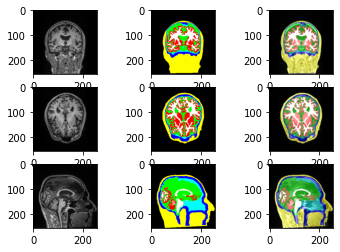

In [6]:
image, contour = converter(2)
check(check_n, image, contour)